In [1]:
import numpy as np
import matplotlib.pyplot as plt

# https://rdr.ucl.ac.uk/articles/dataset/Recording_with_a_Neuropixels_probe/25232962/1

# from params.py
# dat_path = 'Hopkins_20160722_g0_t0.imec.ap_CAR.bin'
# n_channels_dat = 385
# dtype = 'int16'
# offset = 0
# sample_rate = 30000
# hp_filtered = False

# https://github.com/kwikteam/phy-contrib/blob/master/docs/template-gui.md

inputfilename = 'Hopkins_20160722_g0_t0.imec.lf.bin' #using this file that seems like a subset of the full recording
nrows = 385
with open(inputfilename, 'rb') as fid:
    data_array = np.fromfile(fid, np.int16).reshape((-1, nrows)).T
data_array.shape

(385, 9434064)

In [2]:
chanMap = np.load('channel_map.npy').ravel() # using ravel to get rid of empty 2nd dim
spk_ts = np.load('spike_times.npy').ravel() 
chanPos = np.load('channel_positions.npy')

In [3]:
# Get high-pass filtering procedures from Kilosort 4
#https://github.com/MouseLand/Kilosort/blob/main/kilosort/preprocessing.py

from scipy.signal import butter, filtfilt
def get_highpass_filter(fs=30000, cutoff=300):#, device=torch.device('cuda')):
    """Filter to use for high-pass filtering."""
    NT = 30122
    
    # a butterworth filter is specified in scipy
    b,a = butter(3, cutoff, fs=fs, btype='high')

    # a signal with a single entry is used to compute the impulse response
    x = np.zeros(NT)
    x[NT//2] = 1

    # symmetric filter from scipy
    hp_filter = filtfilt(b, a , x).copy()
    
    #hp_filter = torch.from_numpy(hp_filter).to(device).float()
    return hp_filter

def filter_(X, ops=None, ibatch=None):
    # pick only the channels specified in the chanMap
    if chan_map is not None:
        X = X[chan_map]

    if invert_sign:
        X = X * -1

    X = X - X.mean(1).unsqueeze(1)
    if do_CAR:
        # remove the mean of each channel, and the median across channels
        X = X - torch.median(X, 0)[0]

    # high-pass filtering in the Fourier domain (much faster than filtfilt etc)
    if hp_filter is not None:
        fwav = fft_highpass(hp_filter, NT=X.shape[1])
        X = np.real(ifft(fft(X) * np.conj(fwav)))
        X = fftshift(X, dim = -1)

    if artifact_threshold < np.inf:
        if torch.any(torch.abs(X) >= artifact_threshold):
            # Assume the batch contains a recording artifact.
            # Skip subsequent preprocessing, zero-out the batch.
            return torch.zeros_like(X)

    # whitening, with optional drift correction
    if whiten_mat is not None:
        if dshift is not None and ops is not None and ibatch is not None:
            M = get_drift_matrix(ops, dshift[ibatch], device=device)
            #logger.info(M.dtype, X.dtype, whiten_mat.dtype)
            X = (M @ whiten_mat) @ X
        else:
            X = whiten_mat @ X
    return X

def fft_highpass(hp_filter, NT=30122):
    """Convert filter to fourier domain."""
#     device = hp_filter.device
    ft = hp_filter.shape[0]

    # the filter is padded or cropped depending on the size of NT
    if ft < NT:
        pad = (NT - ft) // 2
        fhp = fft(np.concatenate((np.zeros(pad), 
                             hp_filter,
                             np.zeros(pad + (NT-pad*2-ft)))))
    elif ft > NT:
        crop = (ft - NT) // 2 
        fhp = fft(hp_filter[crop : crop + NT])
    else:
        fhp = fft(hp_filter)
    return fhp

In [8]:
from numpy.fft import fft, ifft, fftshift
sample_rate = 30000
length_secs_to_use = 10 # work with a short snippet of the data -- makes sense if we want to eventually do this online

# filter raw data
hp_filter = get_highpass_filter(sample_rate)
X = data_array[:, :length_secs_to_use * sample_rate]

# select only the channel in chanMap
X = X[chanMap]

# apply filter in Fourier space
fwav = fft_highpass(hp_filter, NT=X.shape[1])
X = np.real(ifft(fft(X) * np.conj(fwav)))
X = fftshift(X, axes = -1)

#compute std dev's for each channel separately
chan_stds = X.std(1)

In [13]:
# SPIKE DETECTION
# Simplification: detect spikes simply as events where amplitude < -6*std (per channel)

global_boolean_spks = X < -6*chan_stds[:,None]


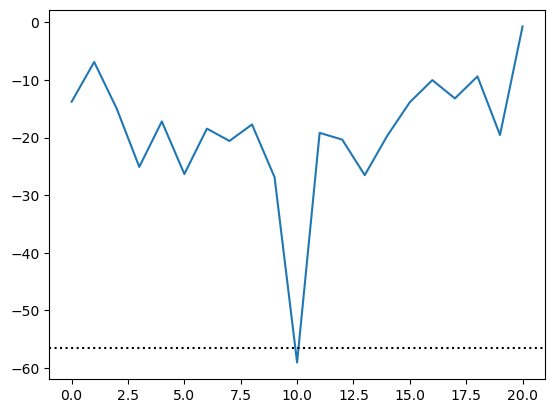

In [14]:
# plot an example of window around a spike for a single channel and show the threshold used with that channel
chan = 0 #pick channel index
spki = 3 #pick spike number for that channel
spk_ix = np.flatnonzero(global_boolean_spks[chan])[spki] # find spike temporal index 

half_window = 10 

plt.plot(X[chan, spk_ix - half_window : spk_ix + half_window + 1])
plt.axhline(-6*chan_stds[chan],c='k',ls=':')

In [15]:
# DATASET: collect windows around spikes across all channels

nChannels =  X.shape[0]
#ignore spikes happening at the very beginning or the very end (just so we don't need to deal with padding)
global_boolean_spks[:,:half_window] = False
global_boolean_spks[:,-half_window:] = False

nSpikes = global_boolean_spks.sum()
all_spk_windows = np.zeros((nSpikes, nChannels, half_window*2 + 1))
spk_coords = list(zip(*np.nonzero(global_boolean_spks))) # channel, time
# sort them by time
spk_coords = sorted(spk_coords, key=lambda x: x[1])

spk_channels = np.zeros(nSpikes, dtype='int') #keep a list of the channels where each spike in `all_spk_windows` came from
for wi, (chan_i, spk_ti) in enumerate(spk_coords):
    all_spk_windows[wi] = X[:, spk_ti - half_window : spk_ti + half_window + 1]
    spk_channels[wi] = chan_i

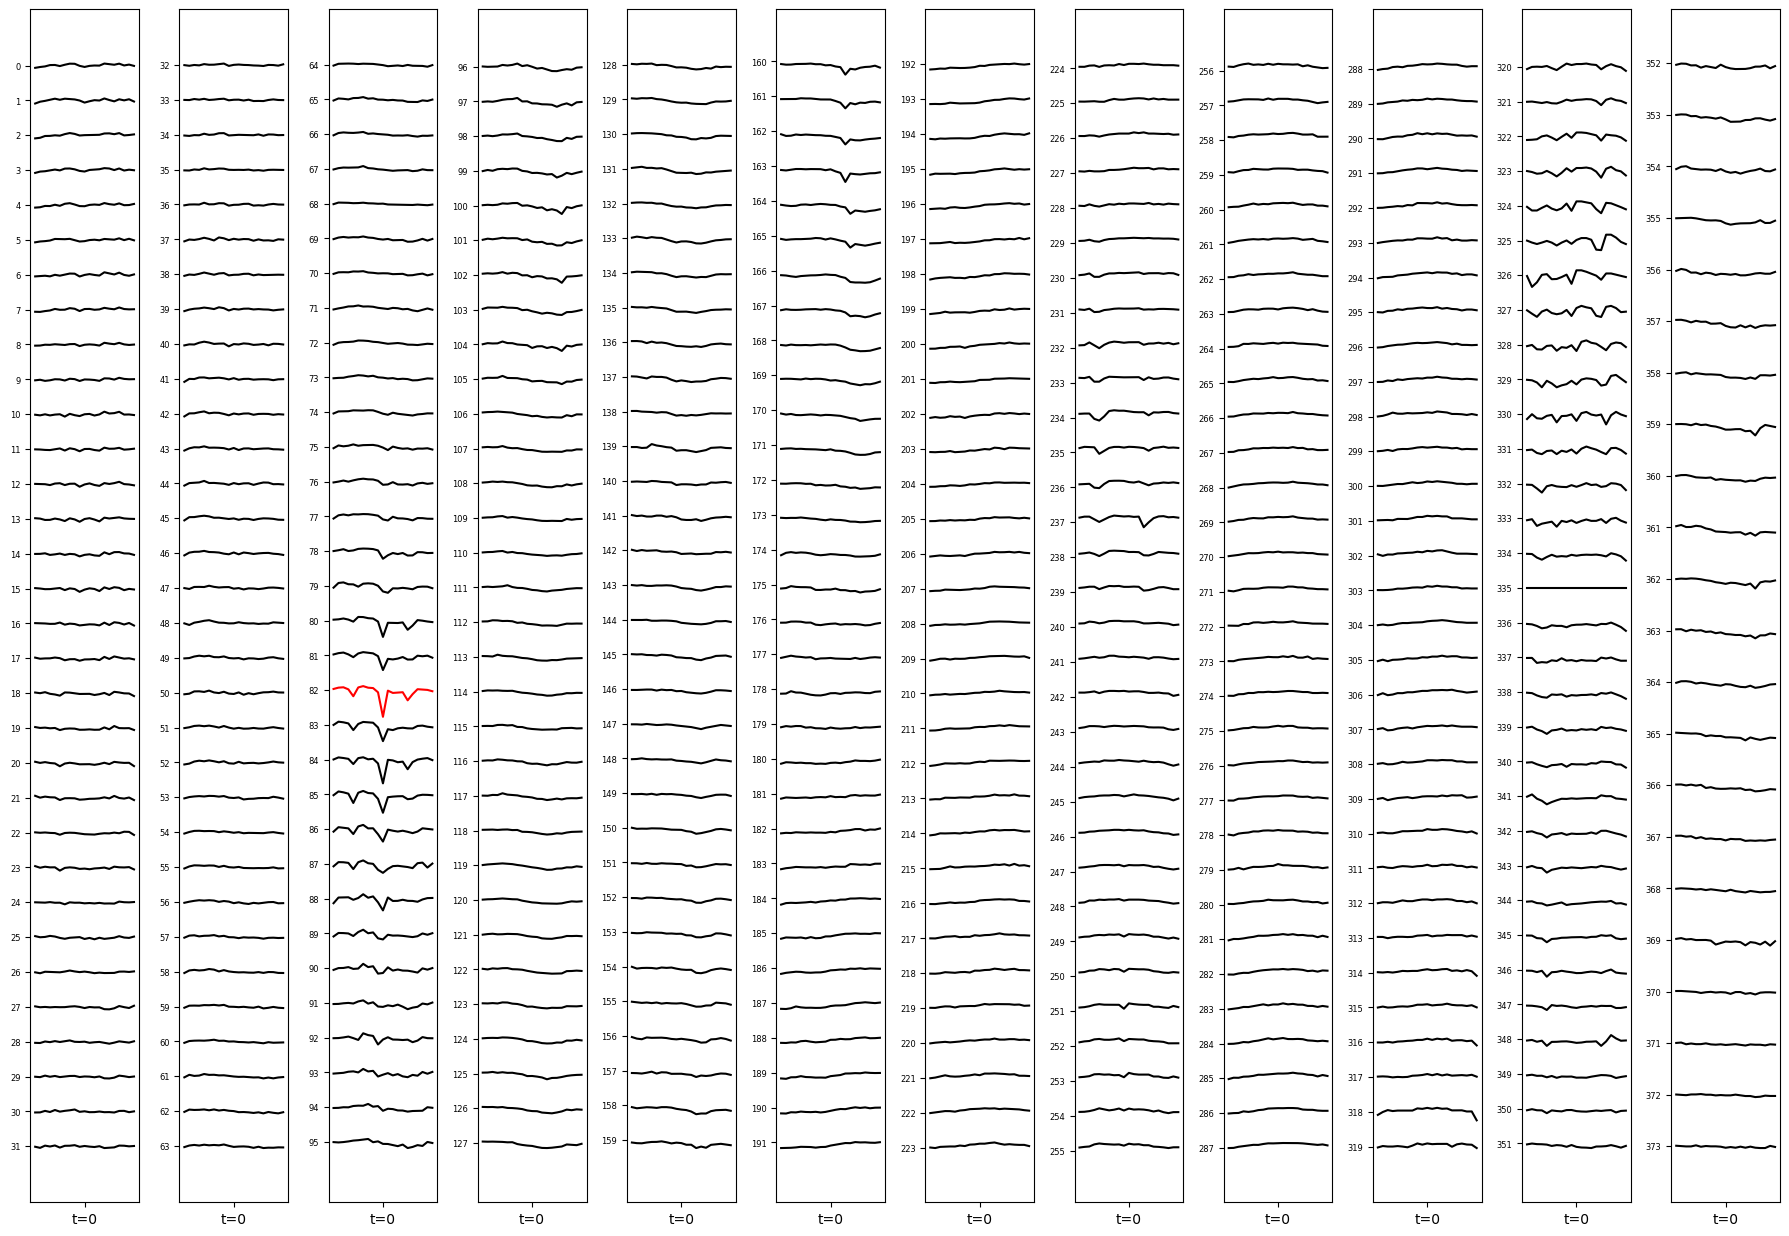

In [60]:
# plot the window for all channels around a (global) spike 

spki = 2

delta = all_spk_windows[spki].max() - all_spk_windows[spki].min()
nChannels =  X.shape[0]

ncols = 12 #split the channels into different subplots to prevent fig from getting too tall
chansPerCol = int(np.ceil(nChannels/ncols))

f, axes = plt.subplots(1, ncols, figsize=(1.5 * ncols, nChannels*.4/ncols))
for col in range(ncols):
    ax = axes[col]
    chan_is = np.arange(col*chansPerCol, min(nChannels, (col+1)*chansPerCol))
    for chan_i in range(col*chansPerCol, min(nChannels, (col+1)*chansPerCol)):
        # check if this is the channel the spike came from -- label it with red
        thisChan = spk_channels[spki] == chan_i
        ax.plot(all_spk_windows[spki,chan_i] - chan_i*delta, color='r' if thisChan else 'k')
    
    ax.set(xticks=[half_window], xticklabels=['t=0'], yticks=-chan_is*delta)
    ax.set_yticklabels(chan_is, size=6)
f.tight_layout()
plt.show()

Text(0, 0.5, 'Expl. variance ratio')

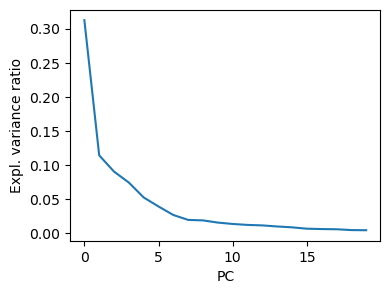

In [36]:
# apply PCA to reduce dimensionality of each (nChans x time_window)-dimensional spike 

data = all_spk_windows.reshape(nSpikes, -1) #concatenate the windows of all channels together

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=20, random_state=0))])

Y = pipeline.fit_transform(data)

plt.figure(figsize=(4,3))
plt.plot(pipeline[1].explained_variance_ratio_)
plt.xlabel('PC')
plt.ylabel('Expl. variance ratio')

In [ ]:
# visualize a PC

PCi = 0
PC_windows = pipeline[1].components_[PCi].reshape(nChannels,-1)
delta = PC_windows.max() - PC_windows.min()
ncols = 12 #split the channels into different subplots to prevent fig from getting too tall
chansPerCol = int(np.ceil(nChannels/ncols))

f, axes = plt.subplots(1, ncols, figsize=(1.5 * ncols, nChannels*.4/ncols))
for col in range(ncols):
    ax = axes[col]
    for chan_i in range(col*chansPerCol, min(nChannels, (col+1)*chansPerCol)):
        ax.plot(PC_windows[chan_i] + chan_i*delta, color='k')
    ax.set(yticks=[], xticks=[half_window], xticklabels=['t=0'])

plt.show()

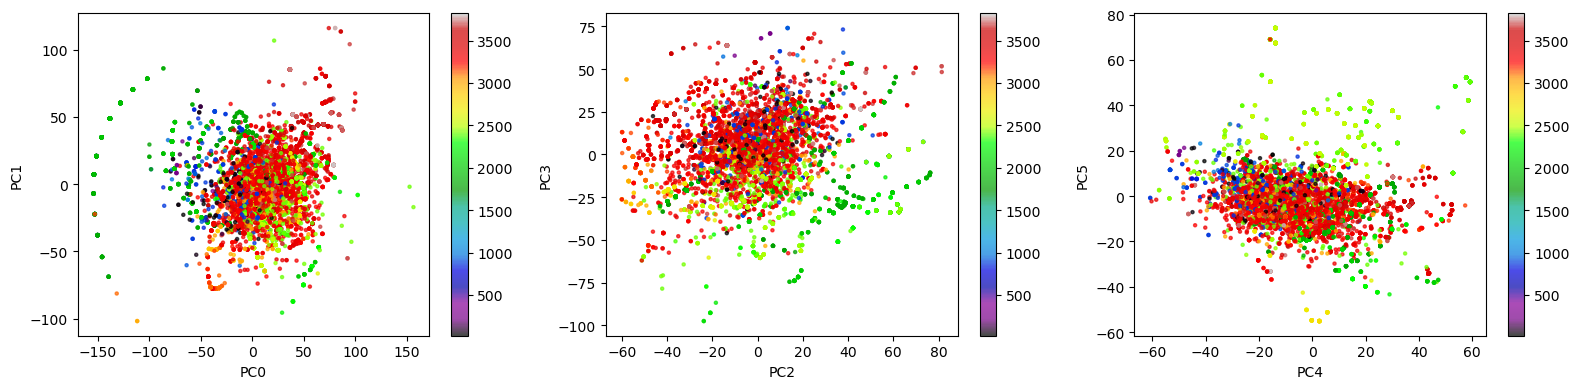

In [38]:
# all spikes embedded in PCs, labeled by the source channel depth

channel_depths = chanPos[spk_channels,1]


PCs = [(0,1), (2,3), (4,5)] #look through multiple PC coordinates

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))
for ax, pcs in zip(axes, PCs):
    sc = ax.scatter(*Y[:,pcs].T, c=channel_depths, cmap='nipy_spectral', alpha=.7, s=5)
    f.colorbar(sc, ax=ax)
    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
f.tight_layout()
plt.show()


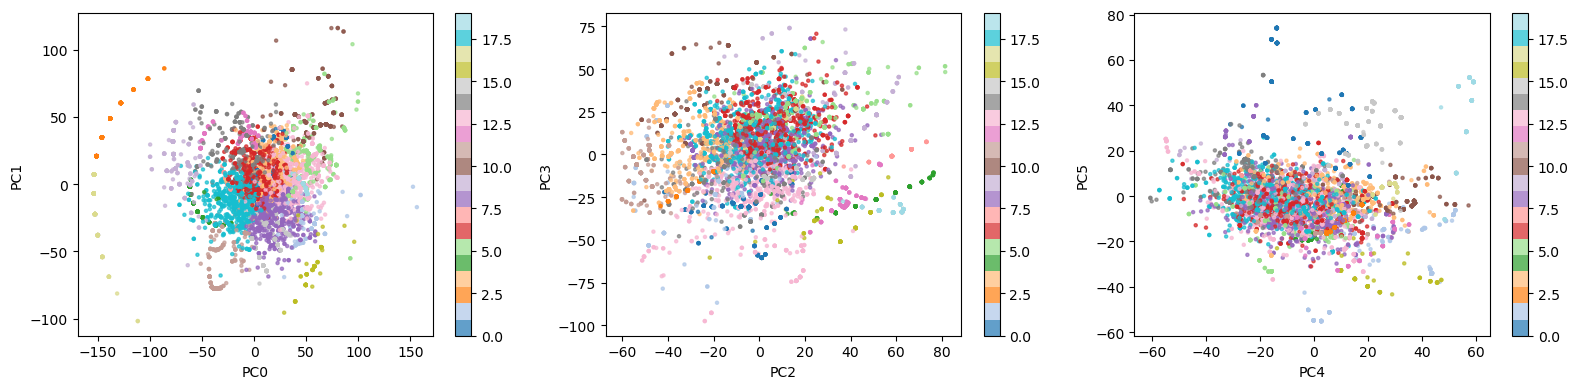

In [39]:
# now apply K-Means cluster the spikes in these reduced coordinates

from sklearn.cluster import KMeans
K = 20
kmeans = KMeans(K, random_state=0)
m = 10 # number of PCs to use
kmeans.fit(Y[:,:m])


# plot all spikes embedded in PCs
PCs = [(0,1), (2,3), (4,5)]
f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))
for ax, pcs in zip(axes, PCs):
    sc = ax.scatter(*Y[:,pcs].T, c=kmeans.labels_, cmap='tab20', alpha=.7, s=5)
    f.colorbar(sc, ax=ax)
    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
f.tight_layout()
plt.show()


50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 


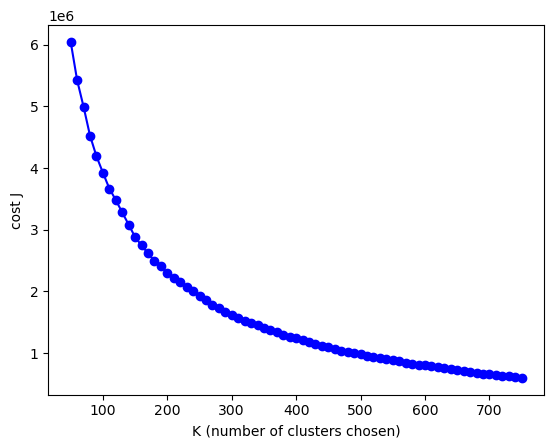

In [43]:
from sklearn.cluster import KMeans

Js = []
Ks = range(50,2*nChannels+10,10)

for K in Ks:
    print(K,end=' ')
    est = KMeans(K, random_state=0) 
    est.fit(Y[:,:m])
    Js.append(est.inertia_)
print()
ax = plt.subplot(111)
ax.plot(Ks, Js,'bo-')
ax.set_ylabel('cost J')
ax.set_xlabel('K (number of clusters chosen)')

plt.show()

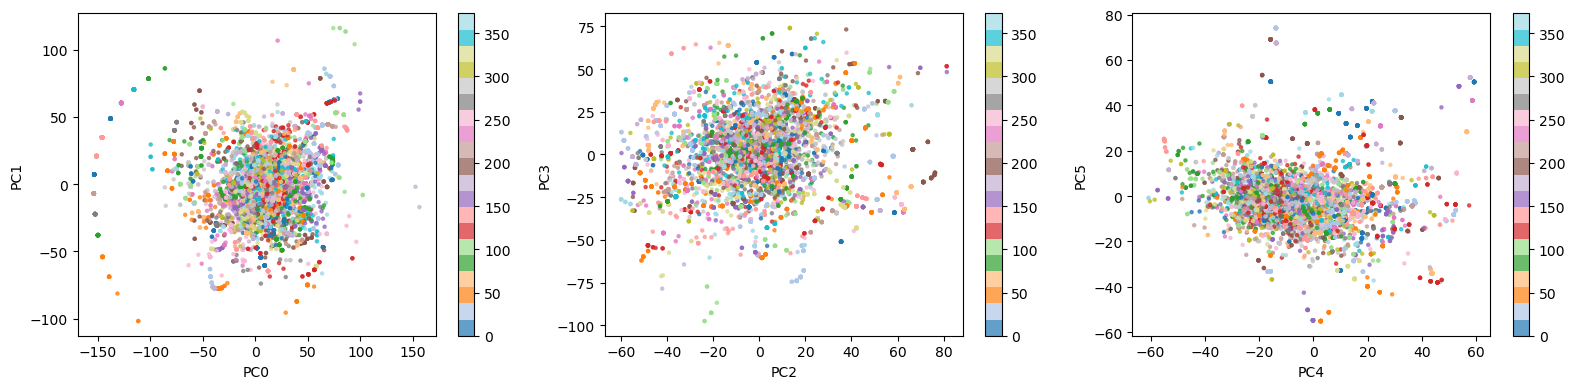

In [44]:
# use K = nChannels

from sklearn.cluster import KMeans
K = nChannels
kmeans = KMeans(K, random_state=0)
m = 10 # number of PCs to use
kmeans.fit(Y[:,:m])


# plot all spikes embedded in PCs
PCs = [(0,1), (2,3), (4,5)]
f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))
for ax, pcs in zip(axes, PCs):
    sc = ax.scatter(*Y[:,pcs].T, c=kmeans.labels_, cmap='tab20', alpha=.7, s=5)
    f.colorbar(sc, ax=ax)
    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
f.tight_layout()
plt.show()


In [ ]:
# visualize a centroid

k = 292
centroid_windows = data[kmeans.labels_ == k].mean(0).reshape(nChannels,-1)
delta = centroid_windows.max() - centroid_windows.min()
ncols = 12 #split the channels into different subplots to prevent fig from getting too tall
chansPerCol = int(np.ceil(nChannels/ncols))

f, axes = plt.subplots(1, ncols, figsize=(1.5 * ncols, nChannels*.4/ncols))
for col in range(ncols):
    ax = axes[col]
    for chan_i in range(col*chansPerCol, min(nChannels, (col+1)*chansPerCol)):

        ax.plot(centroid_windows[chan_i] + chan_i*delta, color='k')
    ax.set(yticks=[], xticks=[half_window], xticklabels=['t=0'])

plt.show()

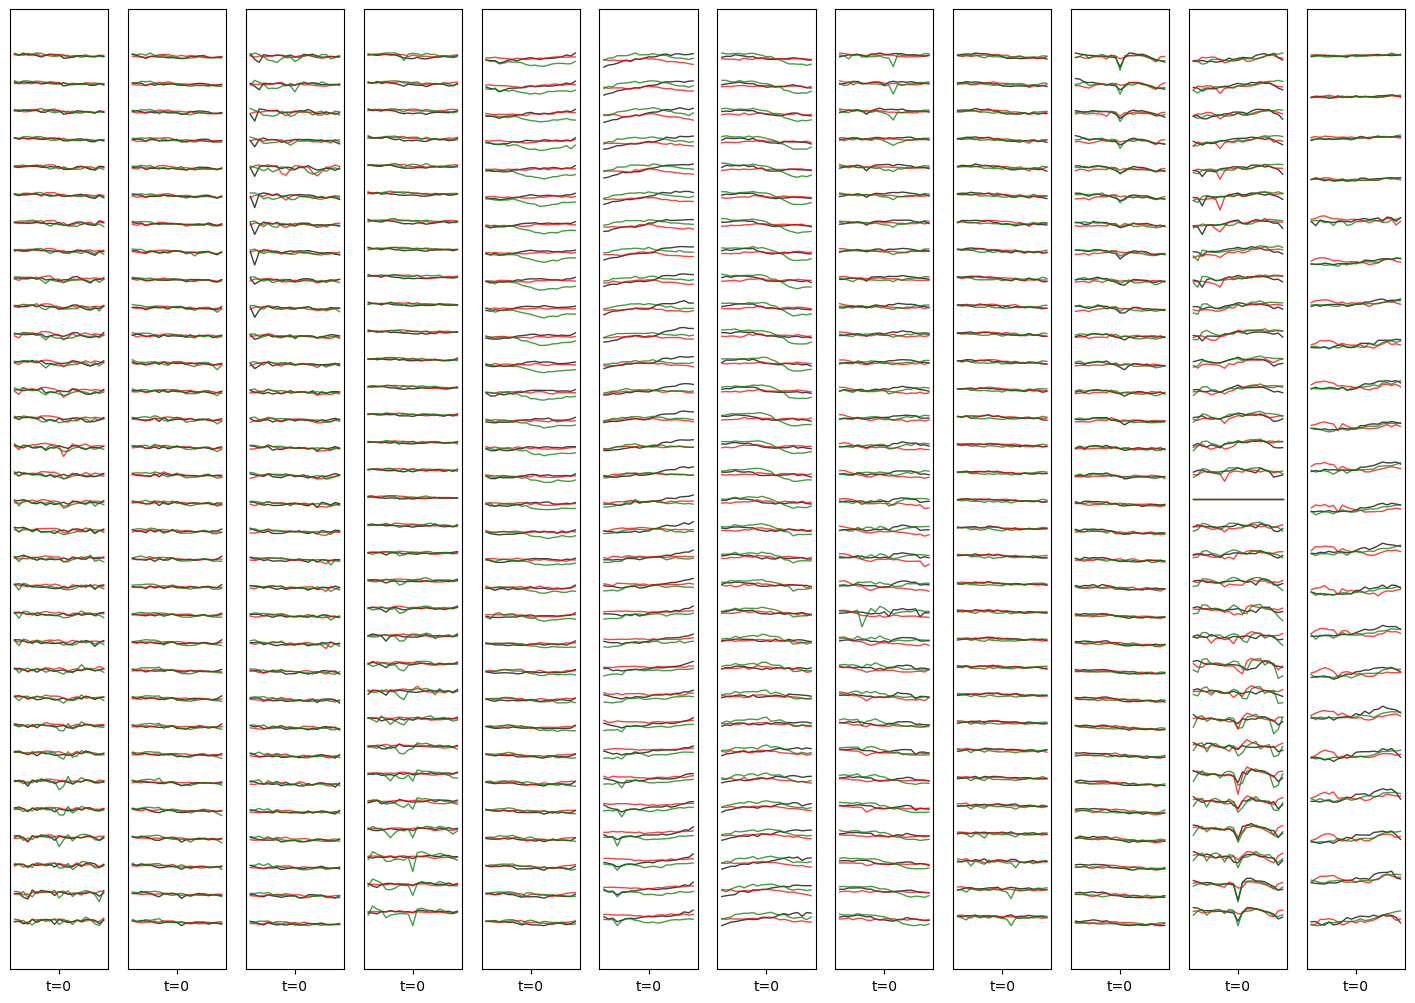

In [73]:
# plot nearest neighbor spikes to centroid
from scipy.spatial.distance import cdist
k = 1 # pick cluster 
dists_to_centroid = cdist(kmeans.cluster_centers_[k][None,:], Y[:,:m])[0]
nearest_neighbors = np.argsort(dists_to_centroid)

# visualize a nearest neighbor
nnis =  [0, 1, 2] #pick NN indices
colors=['k','r','g']
windows = [data[nearest_neighbors[nni]].reshape(nChannels,-1) for nni in nnis]
delta = max([windows[nni].max() - windows[nni].min() for nni in nnis])
ncols = 12 #split the channels into different subplots to prevent fig from getting too tall
chansPerCol = int(np.ceil(nChannels/ncols))

f, axes = plt.subplots(1, ncols, figsize=(1.5 * ncols, nChannels*.4/ncols))



for nni in nnis:
    for col in range(ncols):
        ax = axes[col]
        for chan_i in range(col*chansPerCol, min(nChannels, (col+1)*chansPerCol)):

            ax.plot(windows[nni][chan_i] + chan_i*delta, color=colors[nni], lw=1, alpha=0.75)
        ax.set(yticks=[], xticks=[half_window], xticklabels=['t=0'])

plt.show()

In [ ]:
# PROBLEM: we shouldnt be comparing all channels together since spikes only leave a mark in a small subset of them
# TODO: try matrix factorization to discover which subsets of channels consistently show the same "multi-pattern" across the recording
